In [1]:
#@title Imports { vertical-output: true, form-width: "15%" }
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os.path
import matplotlib.style as style 
from google.colab import drive
drive.mount('/content/drive')
sns.set(style="darkgrid")
style.use('tableau-colorblind10')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@title Parameter Settings { vertical-output: true, form-width: "15%" }

#reading in parameter settings and creating dict for data viz
os.chdir('/content/drive/MyDrive/KAUST!!/researchProj/ammoniaProduction/outputAnalysis')

pdSingleParamDataset = pd.read_excel(f"../dataInputs/inputSheet.xlsx",sheet_name='systemSettings')
pdEyParamDataset = pd.read_excel("../dataInputs/inputSheet.xlsx",sheet_name='eyUnitSettings')
#cfWind = pd.read_excel("../dataInputs/reData.xlsx",sheet_name='cfWind')
#cfSolar = pd.read_excel("../dataInputs/reData.xlsx",sheet_name='cfSolar')


parameterSettingsDict = {}

for paramName,paramValue in zip(pdSingleParamDataset["ParamName"],pdSingleParamDataset["Value"]):
    parameterSettingsDict[paramName] = paramValue

#setting plot style
plt.rcParams["font.family"] = "serif"

In [15]:
#@title Read in multiple time periods and average over sites data { form-width: "15%" }

totalTimePeriods = ["2017","2018","2019"]
sites = ["northWest","centralWest","northEast"]
costDataColNames = ["windCosts","solarCosts","bsPowerCosts","bsEnergyCosts",
                    "eyCosts","hsCosts","asuCosts","hbCosts"]



#master dataset (holds all data from different times with cost breakdown)
masterDataset = {}

for site in sites:
  
  #used for inputting final data into master dataset
  masterTempDict = {}
  for costDataCol in costDataColNames:
    masterTempDict[costDataCol] = []

  for timePeriod in totalTimePeriods:

    #used for averaging two year runs
    averageTempDict = {}
    for costDataCol in costDataColNames:
      averageTempDict[costDataCol] = 0

    for yearPart in [0,1]:
      #reading in output from optimization model and setting up structure for data viz
      #excelName = f"northWestSite_{timePeriod[0]}_{timePeriod[1]}"
      excelName = f"{site}_part{yearPart}_{timePeriod}"

      #getting out year results for site
      singleValueData = pd.read_excel(f"../modelOutputs/baseResults/{site}/{excelName}.xlsx",sheet_name="singleValueDvs").abs()

      #adding to each cost data col the respective year cost-later averaged out
      for costDataCol in costDataColNames:
        averageTempDict[costDataCol] += singleValueData[costDataCol][0]

    #appending to cost list the average over the two runs for that year
    for costDataCol in costDataColNames:
      masterTempDict[costDataCol].append(averageTempDict[costDataCol]/2)

  #putting into final master dataset structure
  for costDataCol in costDataColNames:
    masterDataset[site,costDataCol] = np.array(masterTempDict[costDataCol])


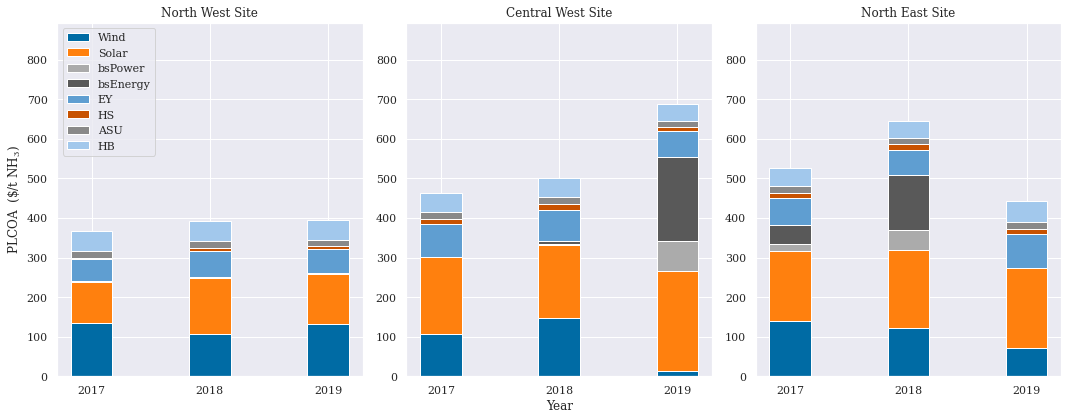

In [16]:
#@title Main Paper Figure 1 { form-width: "15%" }
costComponents = ["windCosts","solarCosts","bsPowerCosts","bsEnergyCosts","eyCosts","hsCosts",
                                        "asuCosts","hbCosts"]

labelList = ["Wind","Solar","bsPower","bsEnergy","EY","HS","ASU","HB"]
titleList = ["North West Site", "Central West Site", "North East Site"]
sites = ["northWest","centralWest","northEast"]
labels = totalTimePeriods
width = 0.35 


#getting max totalCost for each site and year (need to sum up cost components)
maxCost = 0
for site in sites:
  for year in [0,1,2]:
    totalCost = 0
    for costComponent in costComponents:
      totalCost += 1000*masterDataset[site,costComponent][year]

    #checking to see if cost is greater than max
    if(totalCost > maxCost):
      maxCost = totalCost   


maxCost = totalCost + 450


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

for siteCount,site in enumerate(sites):
  barBottomNum = 0
  for costColCount,costDataCol in enumerate(costDataColNames): 
    ax[siteCount].bar(labels, 1000*masterDataset[site,costDataCol], width, bottom=barBottomNum,  label=labelList[costColCount])

    #adding bottom of bar
    barBottomNum += 1000*masterDataset[site,costDataCol]


  #adding graph information
  if(siteCount == 0):
    ax[siteCount].set_ylabel('PLCOA  (\$/t $NH_{3}$)')
    ax[siteCount].set_title(titleList[siteCount])
    ax[siteCount].set_ylim(top=maxCost)
    ax[siteCount].legend(loc="upper left")
  else:
    ax[siteCount].set_title(titleList[siteCount])
    ax[siteCount].set_ylim(top=maxCost)
  if(siteCount == 1):
    ax[siteCount].set_xlabel('Year')    

plt.tight_layout()
plt.show()


In [14]:
#@title Main Paper Figure 2-load data { form-width: "15%" }

#reading in output from optimization model and setting up structure for data viz
'''site = "northWest"
year = "2017"
yearPart = 1 

outputFileName = f"../modelOutputs/baseResults/{site}/{site}_part{yearPart}_{year}.xlsx"'''

site = "northWest"
startDay = 0
endDay = 180 

outputFileName = f"../modelOutputs/3QuarterYearRuns/{site}Site_base_{startDay}_{endDay}.xlsx"


singleValueData = pd.read_excel(outputFileName,sheet_name="singleValueDvs").abs()

singleEyValueData = pd.read_excel(outputFileName,sheet_name="singleEyValueDvs")

hourlySingleValueData = pd.read_excel(outputFileName,sheet_name="hourlyValueDvs").abs()

hourlyEyValueData = pd.read_excel(outputFileName,sheet_name="hourlyEyValueDvs").abs()

hourlyEyValueData.head()

combinedDf = pd.concat([hourlySingleValueData,hourlyEyValueData.rename(columns={0: "eyGen"})], axis=1, join='inner')

#summing up generation of all EY models
for colIndex in np.arange(len(hourlyEyValueData.columns)-1):
    if(colIndex == 0):
        summedEyGeneration = hourlyEyValueData[0]
    else:
        summedEyGeneration +=  hourlyEyValueData[colIndex]
        
summedEyGeneration = summedEyGeneration.rename("eyGen")
        
combinedDf = pd.concat([hourlySingleValueData,summedEyGeneration], axis=1, join='inner')


#cleaning up combined data and adding new column for data analysis purposes
del combinedDf["Unnamed: 0"]
combinedDf["eyDirectToHb"] = combinedDf["eyGen"] - (combinedDf["hsStore"]/parameterSettingsDict["hsDeployEfficiency"])

singleValueData["bsCosts"] = singleValueData["bsPowerCosts"] + singleValueData["bsEnergyCosts"]

windTotalCost = (singleValueData["windCosts"]/singleValueData["LCOA"])*singleValueData["totalSystemCost"]
solarTotalCost = (singleValueData["solarCosts"]/singleValueData["LCOA"])*singleValueData["totalSystemCost"]
#singleValueData.head()

#calcuting energy demand
combinedDf["energyConsumptionEY"] = combinedDf["eyGen"]*pdEyParamDataset["energyUseEY"][0]
combinedDf["energyConsumptionASU"] = combinedDf["asuGen"]*parameterSettingsDict["energyUseASU"]
combinedDf["energyConsumptionHB"] = combinedDf["hbGen"]*parameterSettingsDict["energyUseHB"]
combinedDf["energyConsumptionBS"] = combinedDf["bsStore"]/parameterSettingsDict["bsStoreEfficiency"]
combinedDf["energyConsumptionHS"] = combinedDf["hsAvail"]*parameterSettingsDict["energyUseHS"]

#calculating direct hydrogen flow to ammonia plant
combinedDf["hydrogenDirectEY"] = (combinedDf["eyGen"] - combinedDf["hsStore"]/parameterSettingsDict["hsStoreEfficiency"])


#converting data to tonnes
#changing plot Data
plotNames = ["windGen","solarGen","bsAvail",
             "energyConsumptionHB","energyConsumptionASU","energyConsumptionEY",
             "energyConsumptionHS","energyConsumptionBS","eyGen","hsDeploy",
             "hsStore","hsAvail","hbGen","asuGen","hydrogenDirectEY"
]
for plotName in plotNames:
  combinedDf[plotName] = combinedDf[plotName]/1000


<ipython-input-16-9f5d348ea9e5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotDf["timestep"] = plotDf["timestep"] - offSet


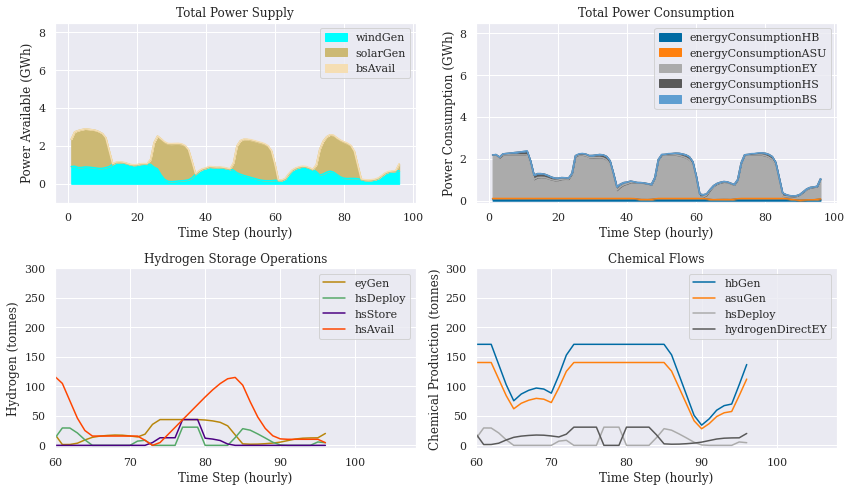

In [16]:
#@title Main Paper: Fig 2 plot results
figure, axes = plt.subplots(2, 2)


#getting out specific dataframe for time period and reseting index for plotting
offSet = 2500
endIndex = offSet + 24*4
plotDf = combinedDf.iloc[offSet:endIndex]
#plotDf = combinedDf
plotDf["timestep"] = plotDf["timestep"] - offSet


#plotting total power supply in top left
plotDf.plot.area(x="timestep", y=["windGen","solarGen","bsAvail"],figsize=(12, 7),
                ax=axes[0,0],style=["aqua","y","wheat"],
                title="Total Power Supply",xlabel="Time Step (hourly)",
                ylabel = "Power Available (GWh)",ylim=[-1,8.5])

#plotting total power demand in top right
plotDf.plot.area(x="timestep", y=["energyConsumptionHB","energyConsumptionASU","energyConsumptionEY","energyConsumptionHS","energyConsumptionBS"],
                figsize=(12, 7),ax=axes[0,1],
                title="Total Power Consumption",xlabel="Time Step (hourly)",
                ylabel = "Power Consumption (GWh)",ylim=[-.1,8.5])


plotDf.plot(x="timestep", y=["eyGen","hsDeploy","hsStore","hsAvail"],
                figsize=(12, 7),ax=axes[1,0],style=["darkgoldenrod","g","indigo","orangered"],
                title="Hydrogen Storage Operations",xlabel="Time Step (hourly)",
                ylabel = "Hydrogen (tonnes)",xlim=[60, 108],ylim=[-5,300])

plotDf.plot(x="timestep", y=["hbGen","asuGen","hsDeploy","hydrogenDirectEY"],
                figsize=(12, 7),ax=axes[1,1],
                title="Chemical Flows",xlabel="Time Step (hourly)",
                ylabel = "Chemical Production (tonnes)",xlim=[60, 108],ylim=[-5,300])

#fixing legend locations
axes[1,0].legend(loc="upper right")
plt.tight_layout()

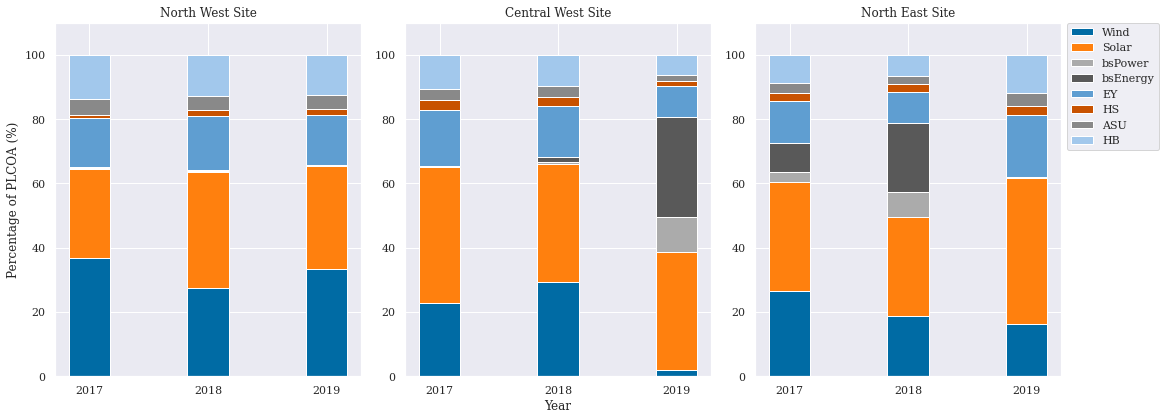

In [17]:
#@title SI Fig 1-Percentage Costs { form-width: "15%" }
plt.rcParams["font.family"] = "serif"

costComponents = ["windCosts","solarCosts","bsPowerCosts","bsEnergyCosts","eyCosts","hsCosts",
                                        "asuCosts","hbCosts"]

labelList = ["Wind","Solar","bsPower","bsEnergy","EY","HS","ASU","HB"]
titleList = ["North West Site", "Central West Site", "North East Site"]
sites = ["northWest","centralWest","northEast"]
labels = totalTimePeriods
width = 0.35 

#max cost is on percentage basis
maxCost = 110

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

for siteCount,site in enumerate(sites):
  barBottomNum = 0.0

  #getting total cost first for percentages
  totalCost = 0.0
  for costColCount,costDataCol in enumerate(costDataColNames): 
    totalCost += masterDataset[site,costDataCol]

  for costColCount,costDataCol in enumerate(costDataColNames): 
    ax[siteCount].bar(labels, 100.0*masterDataset[site,costDataCol]/totalCost, width, bottom=barBottomNum,  label=labelList[costColCount])

    #adding bottom of bar
    barBottomNum += 100.0*masterDataset[site,costDataCol]/totalCost
  
  #adding graph information
  if(siteCount == 0):
    ax[siteCount].set_ylabel('Percentage of PLCOA (%)')
    ax[siteCount].set_title(titleList[siteCount])
    ax[siteCount].set_ylim(top=maxCost)
    #ax[siteCount].legend(loc="upper left")
  else:
    ax[siteCount].set_title(titleList[siteCount])
    ax[siteCount].set_ylim(top=maxCost)

  #adding year to bottom of axis
  if(siteCount == 1):
    ax[siteCount].set_xlabel('Year')    
  
plt.tight_layout()
ax[2].legend(bbox_to_anchor=(1, 1.015))
plt.show()

In [19]:
#@title SI Fig 2- Sensitivity tests Load in data { form-width: "15%" }


#NEED to load in data from different folders of part0 and part1, average PLCOA, then plot against change in CAPEX

#@title Main Paper Sensitivity Tests Data Load { form-width: "15%" }

siteLocation = "centralWestSite"

#setting up correct filenames list and parameter values tested
fileNameList = []
startValue = .5
step = .1
stopValue = 1.6


#master dataset (holds all data from different times)
masterDataset = {}
for key in ["capexSolar","capexWind","WACC","capexEY"]:
    masterDataset[key] = []

for key in ["capexSolar","capexWind","WACC","capexEY"]:
  fileNameList = []
  for value in np.arange(startValue,stopValue,step):
    #going through each part of the year run and averaging across
    averageValue = 0
    for yearPart in [0,1]:
      fileName = f"{siteLocation}_year2018_part_{yearPart}_{key}_{np.round(value,decimals=1)}"
      #reading in output from optimization model and setting up structure for data viz
      singleValueData = pd.read_excel(f"../modelOutputs/{key}/yearPart{yearPart}/{fileName}.xlsx",sheet_name="singleValueDvs").abs()
      averageValue += singleValueData["LCOA"][0]

    #assign average LCOA
    masterDataset[key].append(averageValue/2)



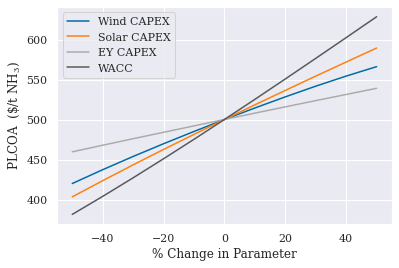

In [20]:
#@title SI Fig 2 Sensitivity Tests Plot { form-width: "15%" }
plt.rcParams["font.family"] = "serif"
fig,ax = plt.subplots()

tickMarks = 100*np.arange(startValue-1,stopValue-1,step)

plt.plot(tickMarks,np.array(masterDataset["capexWind"])*1000,label="Wind CAPEX")
plt.plot(tickMarks,np.array(masterDataset["capexSolar"])*1000,label="Solar CAPEX")
plt.plot(tickMarks,np.array(masterDataset["capexEY"])*1000,label="EY CAPEX")
plt.plot(tickMarks,np.array(masterDataset["WACC"])*1000,label="WACC")

plt.legend()
_ = plt.ylabel('PLCOA  (\$/t $NH_{3}$)')
_ = plt.xlabel("% Change in Parameter")
plt.show()